In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, precision_score, f1_score, recall_score)
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from IPython.display import clear_output
import pickle

# Custom modules
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen

# Model import
from parametricVAE import dVAE
import SVMClassifier
import latentKDEClassifier
# Reload after changes
from importlib import reload
reload(SVMClassifier)
reload(latentKDEClassifier)

# Access the class
from SVMClassifier import SVMClassifier
from latentKDEClassifier import LatentKDEClassifier


### Fetch all datasets

In [2]:
temp =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
temp.shape

(4512, 71)

In [3]:
###### Fetch all ratings across all groups ######
rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')


###### Import BIKED visually reduced dataset ######

dfn = dataFrameTools.normalizeDF(0).astype('float32')
visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)



###### Split rated bikes to usable/unusable ######

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 



##### Import Train and Test Sets ######

input_folder = 'datasets'

X_test = pd.read_csv(os.path.join(input_folder,'X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(input_folder,'y_test.csv'), index_col=0)
X_train = pd.read_csv(os.path.join(input_folder,'X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(input_folder,'y_train.csv'), index_col=0)

X_test_dfn = dfn.loc[X_test.index]
X_train_dfn = dfn.loc[X_train.index]

usable_bikes_train_df = X_train[y_train['usable'] == 1]
unusable_bikes_train_df = X_train[y_train['usable'] == 0]

usable_bikes_test_df = X_test[y_test['usable'] == 1]
unusable_bikes_test_df = X_test[y_test['usable'] == 0]

usable_bikes_test_dfn = dfn.loc[usable_bikes_test_df.index]
usable_bikes_train_dfn = dfn.loc[usable_bikes_train_df.index]
unusable_bikes_test_dfn = dfn.loc[unusable_bikes_test_df.index]
unusable_bikes_train_dfn = dfn.loc[unusable_bikes_train_df.index]


Loaded Imputed Dataframe in  1.351001501083374 seconds


In [4]:
dfn.shape

(4512, 2395)

### Build VAE and get latent representations of usable/unusable bikes


In [5]:
ddims = 2395
tuned_VAE_name = 'augmented_VAE'

dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')
decoder_mean =  dataVAE_mean.get_layer('decoder')

tunedVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
tuned_decoder =  tunedVAE.get_layer('decoder')
tuned_encoder_mean =  tunedVAE.get_layer('encoder')

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 
encoder = tuned_encoder_mean
decoder = tuned_decoder

latent_usable = encoder.predict(usable_bikes)
latent_unusable = encoder.predict(unusable_bikes)

latent_usable_test = encoder.predict(usable_bikes_test_dfn)
latent_usable_train = encoder.predict(usable_bikes_train_dfn)
latent_unusable_test = encoder.predict(unusable_bikes_test_dfn)
latent_unusable_train = encoder.predict(unusable_bikes_train_dfn)
clear_output(wait=False)

### Fit KDEs


In [6]:
def calculate_log_likelihoods_with_cross_validation(bandwidths_usable, bandwidths_unusable, 
                                                    latent_usable_train, latent_unusable_train, 
                                                    n_splits=10, show_report = False):
    
    def calculate_log_odds(dataset, kde):
        log_odds = []
        for point in dataset:
            point = np.reshape(point, (1, -1))  # Ensure correct shape
            log_likelihood = kde.score_samples(point)
            log_odds.append(log_likelihood)
        return log_odds

    best_bandwidth_usable = None
    best_bandwidth_unusable = None
    best_accuracy = -np.inf
    best_preds = []
    best_y_preds = []
    for bw_usable in bandwidths_usable:
        for bw_unusable in bandwidths_unusable:

            accuracies = []
            # Define cross-validation strategy
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            all_preds = []
            all_y_val = []

            # Cross-validation loop
            for (train_usable_idx, val_usable_idx), (train_unusable_idx, val_unusable_idx) in zip(kf.split(latent_usable_train), kf.split(latent_unusable_train)):
                # Fit the KDE models on the training data
                kde_usable = KernelDensity(kernel='gaussian', bandwidth=bw_usable)
                kde_usable.fit(latent_usable_train[train_usable_idx])
                
                kde_unusable = KernelDensity(kernel='gaussian', bandwidth=bw_unusable)
                kde_unusable.fit(latent_unusable_train[train_unusable_idx])

                # Concatenate the validation set (usable + unusable)
                val_set = np.concatenate([latent_usable_train[val_usable_idx], latent_unusable_train[val_unusable_idx]])

                # Create the corresponding labels for the validation set (1 for usable, 0 for unusable)
                y_val = np.concatenate([np.ones(len(val_usable_idx)), np.zeros(len(val_unusable_idx))])

                # Calculate log-odds for both KDEs on the validation set
                log_odds_usable = calculate_log_odds(val_set, kde_usable)
                log_odds_unusable = calculate_log_odds(val_set, kde_unusable)

                # Generate predictions based on log-odds comparison
                preds = [1 if log_odds_usable[i] > log_odds_unusable[i] else 0 
                            for i in range(len(log_odds_usable))]

                # Calculate accuracy of this fold
                accuracy = accuracy_score(y_val, preds)  # Compare predictions with true labels
                # accuracy = f1_score(y_val, preds)
                accuracies.append(accuracy)

                # Append the predictions and true labels for confusion matrix
                all_preds.extend(preds)
                all_y_val.extend(y_val)


            # Return the mean accuracy for this combination of bandwidths
            mean_accuracy =  np.mean(accuracies)

            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_bandwidth_usable = bw_usable
                best_bandwidth_unusable = bw_unusable
                best_preds = all_preds
                best_y_preds = all_y_val

    
    if show_report:
        cm = confusion_matrix(best_y_preds, best_preds)
        ConfusionMatrixDisplay(cm, display_labels=["Unusable", "Usable"]).plot()
        report = classification_report(best_y_preds, best_preds, target_names=["Unusable", "Usable"])
        print(report)

    return best_bandwidth_usable, best_bandwidth_unusable, best_accuracy


## Building SVM Classifier


In [7]:
features = ['Saddle height', 'Stack', 'CS textfield']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

X_feature = X_train_dfn[features].values  
y_train_series = y_train['usable']
svm_clf = SVMClassifier(kernel='poly',C = 600, coef0 = 10, degree= 2, gamma='scale', scaler=1000)
svm_clf.fit(X_feature, y_train_series)  

### Filter poorly represented designs 


In [8]:
latent_kde_classifier = None
features = ['Saddle height', 'Stack', 'CS textfield']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

latent_unusable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
unusable_bids = []
for bid in unusable_bikes_train_df.index:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 0:
        latent_unusable_train_filtered = np.append(latent_unusable_train_filtered, [latent], axis=0)
        unusable_bids.append(bid)


latent_usable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
usable_bids = []
for bid in usable_bikes_train_df.index:
    bike = usable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 1:
        latent_usable_train_filtered = np.append(latent_usable_train_filtered, [latent], axis=0)
        usable_bids.append(bid)


clear_output(False)


print(len(latent_usable_train_filtered))
print(len(latent_unusable_train_filtered))


usable_bikes_train_filtered_dfn = usable_bikes_train_dfn.loc[usable_bids]
unusable_bikes_train_filtered_dfn = unusable_bikes_train_dfn.loc[unusable_bids]

# Define the range of bandwidths to test for both KDEs
bandwidths_usable = [i*0.01 + 0.2 for i in range(20)]   # Bandwidths for usable KDE  0.2 - 0.4 with step 0.01
bandwidths_unusable = [i*0.01 + 0.2 for i in range(20)]  # Bandwidths for unusable KDE 0.2 - 0.4 with step 0.01

# Calculate the best bandwidths
best_bandwidth_usable, best_bandwidth_unusable, best_accuracy = calculate_log_likelihoods_with_cross_validation(
    bandwidths_usable,
    bandwidths_unusable,
    latent_usable_train_filtered,
    latent_unusable_train_filtered,
)

print("Best bandwidth for usable KDE:", best_bandwidth_usable)
print("Best bandwidth for unusable KDE:", best_bandwidth_unusable)
print("Best accuracy:", best_accuracy)

latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
latent_kde_classifier.fit(latent_usable_train_filtered, latent_unusable_train_filtered)


33
28
Best bandwidth for usable KDE: 0.28
Best bandwidth for unusable KDE: 0.25
Best accuracy: 0.7885714285714285


In [8]:
# Load filtered KDE classifier
with open("model weights/latent_kde_classifier.pkl", "rb") as f:
    data = pickle.load(f)

latent_kde_classifier = LatentKDEClassifier(data["bandwidth_usable"], data["bandwidth_unusable"])
latent_kde_classifier.fit(data["latent_usable_train"], data["latent_unusable_train"])

### Perform linear and guided interpolation methods

In [9]:
def linear_interpolation(point1, point2, div_by):
    # Points 1 and 2 are returned with the array

    interpolated_points = []
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    direction = (point2 - point1) / div_by
    current_point = point1  
    
    for _ in range(div_by + 1):
        interpolated_points.append(current_point)
        current_point = current_point + direction

    return np.array(interpolated_points)

In [10]:
unusable_bikes_test_df.index.tolist()

[1246, 1771, 2635, 2087, 2738, 4094, 4696, 3927, 1383, 3012]

In [ ]:
# import latentKDEClassifier

# # Reload after changes
# from importlib import reload
# reload(latentKDEClassifier)

# # Access the class
# from latentKDEClassifier import LatentKDEClassifier

# latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, min_confidence_usable=20)
# latent_kde_classifier.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 17ms/step
Point 0: Starting adjustment
Point 0, Step 0: log_likelihood_usable=[-7.28659194], log_likelihood_unusable=[15.67237716]
Point 0, Step 1: log_likelihood_usable=[-4.69614066], log_likelihood_unusable=[13.35190296]
Point 0, Step 2: log_likelihood_usable=[-2.16014266], log_likelihood_unusable=[10.90846961]
Point 0, Step 3: log_likelihood_usable=[0.28583309], log_likelihood_unusable=[8.34003288]
Point 0, Step 4: log_likelihood_usable=[2.65132038], log_likelihood_unusable=[5.66091582]
Point 0: Did not converge within 5 steps, final log_likelihoods - usable=[4.93910985], unusable=[2.87836995]
Point 1: Starting adjustment
Point 1, Step 0: log_likelihood_usable=[-9.84596201], log_likelihood_unusable=[21.45290922]
Point 1, Step 1: log_likelihood_usable=[-8.29718357], log_likelihood_unusable=[19.9123391]
Point 1, Step 2: log_likelihood_usable=[-6.75834684], log_likelihood_unusable=[18.38122804]
Point 1, Step 3: log_likelihood_usable=[-5.2234564

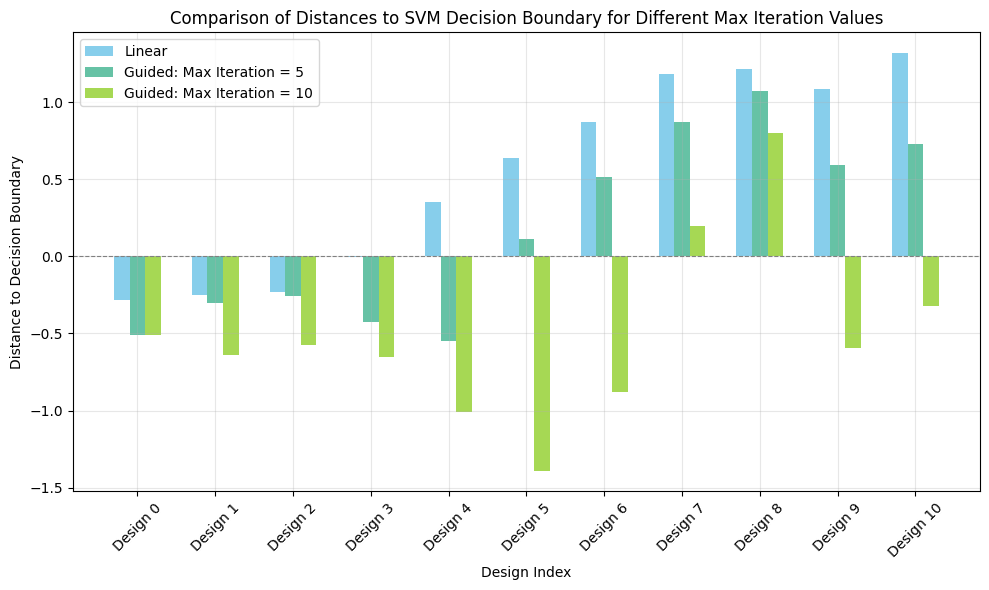

Number of designs that are closer to usable with max_iter=5: 11/11
Number of designs that are closer to usable with max_iter=10: 11/11


In [15]:
latent_kde_classifier.set_min_usable_confidence(None)

# bikes_indices = [8,5]
bikes_indices = [3,2]
latet_int_bikes = latent_unusable_test[bikes_indices]

# linear_interpolated_points = linear_interpolation(latet_int_bikes[0], latet_int_bikes[1], div_by=10)
# new_points = latent_kde_classifier.move_points(linear_interpolated_points, step_scale=0.1, use_direction = 3, max_iter = 10, verbose=True)



max_iters = [5, 10]  # List of max_iter values to test
distances_linear = []
distances_guided_all = {max_iter: [] for max_iter in max_iters}
guided_points_all = {max_iter: [] for max_iter in max_iters}

counts = {max_iter: 0 for max_iter in max_iters}

# Calculate the linear interpolation points once
linear_interpolated_points = linear_interpolation(latet_int_bikes[0], latet_int_bikes[1], div_by=10)

for i in range(len(linear_interpolated_points)):
    linear_point = linear_interpolated_points[i]

    # Linear point
    bike_features_point_linear = (tf.math.sigmoid(tuned_decoder.predict(np.array([linear_point]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point_linear.reshape(1, -1))[0]
    distance_linear = - svm_clf.distance_to_boundary(bike_features_point_linear)[0]
    distances_linear.append(distance_linear)

# Loop over different max_iter values for the guided points
for max_iter in max_iters:
    new_points = latent_kde_classifier.move_points(linear_interpolated_points, step_scale=0.1, use_direction=3, max_iter=max_iter, verbose=True)
    
    # Calculate distances for each guided point
    for i in range(len(new_points)):
        linear_point = linear_interpolated_points[i]
        guided_point = new_points[i]

        # Guided point
        bike_features_point_guided = (tf.math.sigmoid(tuned_decoder.predict(np.array([guided_point]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point_guided.reshape(1, -1))[0]
        distance_guided = - svm_clf.distance_to_boundary(bike_features_point_guided)[0]
        distances_guided_all[max_iter].append(distance_guided)
        guided_points_all[max_iter].append(guided_point)


        if distance_guided <= distances_linear[i]:
            counts[max_iter] += 1

# Plotting
x_indices = np.arange(len(linear_interpolated_points))  # Indices for the x-axis

plt.figure(figsize=(10, 6))

# Plot the linear distances only once (fixed bar position)
plt.bar(x_indices - 0.2, distances_linear, width=0.2, label="Linear", color='skyblue')

# Plot the guided distances for each max_iter value with sufficient spacing
bar_width = 0.2
for idx, max_iter in enumerate(max_iters):
    # Adjust the offset for each set of bars to avoid overlap
    plt.bar(x_indices + (idx * bar_width), distances_guided_all[max_iter], width=bar_width, label=f"Guided: Max Iteration = {max_iter}", color=plt.cm.Set2(idx / len(max_iters)))

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)  # Decision boundary

plt.xlabel("Design Index")
plt.ylabel("Distance to Decision Boundary")
plt.title("Comparison of Distances to SVM Decision Boundary for Different Max Iteration Values")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(x_indices, [f"Design {i}" for i in x_indices], rotation=45)
plt.tight_layout()
plt.show()

# Output counts for each max_iter value
for max_iter in max_iters:
    print(f'Number of designs that are closer to usable with max_iter={max_iter}: {counts[max_iter]}/{len(distances_linear)}')



### Compare interpolation methods in two dimension

### Generate KDE-guided points

In [17]:
new_points = np.array(guided_points_all[5])
res=(tf.math.sigmoid(tuned_decoder.predict(new_points))).numpy()
indices=[f'kde_guided{i}' for i in range(len(new_points))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/temp.csv")  # Saving to CSV

processGen.processGen(f"temp", denorm=True)
clear_output(wait=False)  # This clears the previous print output


### Generate linearly interpolated points

In [18]:
res=(tf.math.sigmoid(tuned_decoder.predict(linear_interpolated_points))).numpy()
indices=[f'inter{i}' for i in range(len(linear_interpolated_points))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/temp.csv")  # Saving to CSV
processGen.processGen(f"temp", denorm=True)
clear_output(wait=False)  # This clears the previous print output


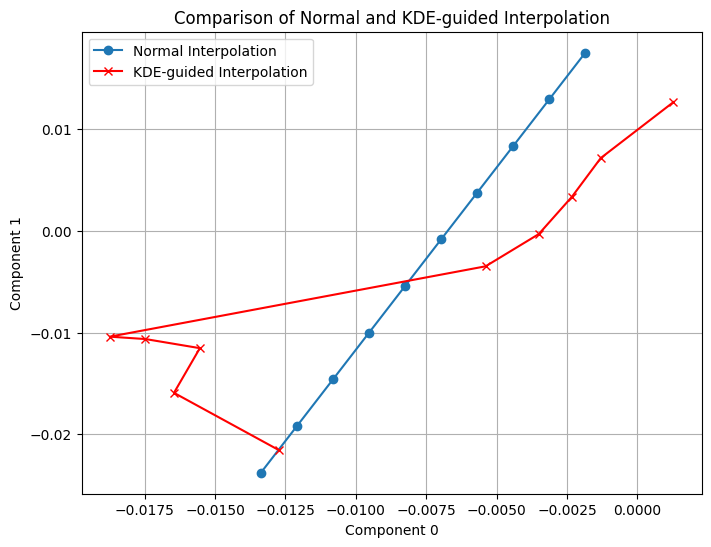

In [79]:

plt.figure(figsize=(8, 6))
comp1 = 0
comp2 = 1

plt.plot(linear_interpolated_points[:, comp1], linear_interpolated_points[:, comp2], 'o-', label='Normal Interpolation')

if len(new_points) > 0:
    plt.plot(new_points[:, comp1], new_points[:, comp2], 'x-', label='KDE-guided Interpolation', color='r')

plt.title('Comparison of Normal and KDE-guided Interpolation')
plt.xlabel(f'Component {comp1}')
plt.ylabel(f'Component {comp2}')
plt.legend()
plt.grid(True)
plt.show()